In [1]:
%pylab inline
import pandas as pd

from mpl_toolkits.axes_grid.inset_locator import inset_axes

Populating the interactive namespace from numpy and matplotlib


/Users/vale/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

In [3]:
results = pd.read_csv('Frog_final_results.csv')
ms_results = pd.read_csv('Frog_MS_results.csv')
sample_info = pd.read_csv('Frog_sample_info.csv', index_col=0)

In [4]:
df = pd.read_csv('data/GSE65785_clutchApolyA_relative_TPM.csv', index_col=0)
df = df[sample_info.index]
df = df[df.sum(1) >= 3]  # Filter practically unobserved genes
dfm = np.log10(df + 1).T

In [5]:
import NaiveDE

In [6]:
dfm = NaiveDE.stabilize(df).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(ERCC) + np.log(num_genes)', rcond=1e-4).T

In [7]:
results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)
ms_results['pval'] = ms_results['pval'].clip_lower(ms_results.query('pval > 0')['pval'].min() / 2)
ms_results['qval'] = ms_results['qval'].clip_lower(ms_results.query('qval > 0')['qval'].min() / 2)

In [8]:
results.shape

(22258, 19)

In [9]:
results.query('qval < 0.05').shape

(21011, 19)

In [10]:
ms_results.model.value_counts()

SE        20501
linear      269
PER         241
Name: model, dtype: int64

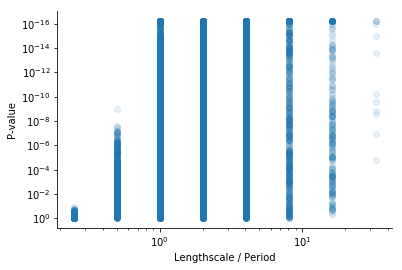

In [11]:
plt.loglog()
plt.scatter(results.l, results.pval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Lengthscale / Period')
plt.ylabel('P-value');

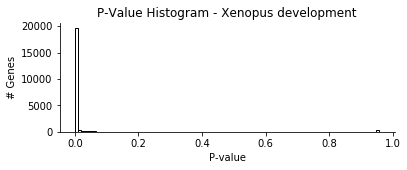

In [12]:
figsize(6, 2)
plt.hist(results.pval, bins=100, color='w', ec='k');
plt.title('P-Value Histogram - Xenopus development')
plt.ylabel('# Genes')
plt.xlabel('P-value');

In [13]:
results.query('qval < 0.05').shape

(21011, 19)

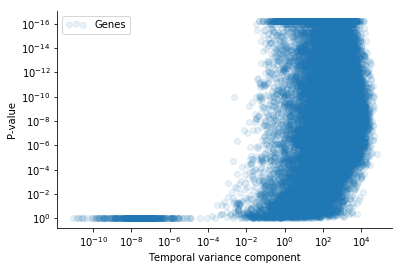

In [14]:
figsize(6, 4)

plt.loglog()
plt.scatter(results.max_s2_t_hat, results.pval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Temporal variance component')
plt.ylabel('P-value');

plt.legend(scatterpoints=3);

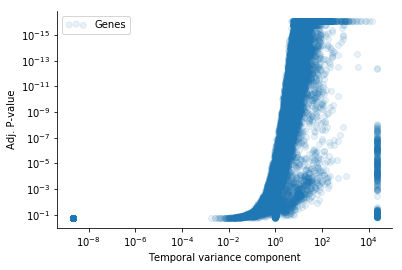

In [15]:
figsize(6, 4)

plt.loglog()
plt.scatter(1 / results.max_delta, results.qval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Temporal variance component')
plt.ylabel('Adj. P-value');

plt.legend(scatterpoints=3);

In [16]:
N = 5
top_per_ls = ms_results \
                  .sort_values('qval', ascending=True) \
                  .groupby(['model', 'l']) \
                  .head(N) \
                  .sort_values(['l', 'qval'], ascending=[True, True])
                
top_per_ls.shape

(71, 22)

In [17]:
model_colors = {'SE': 'C0', 'PER': 'C1', 'linear': 'C2'}

/Users/vale/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


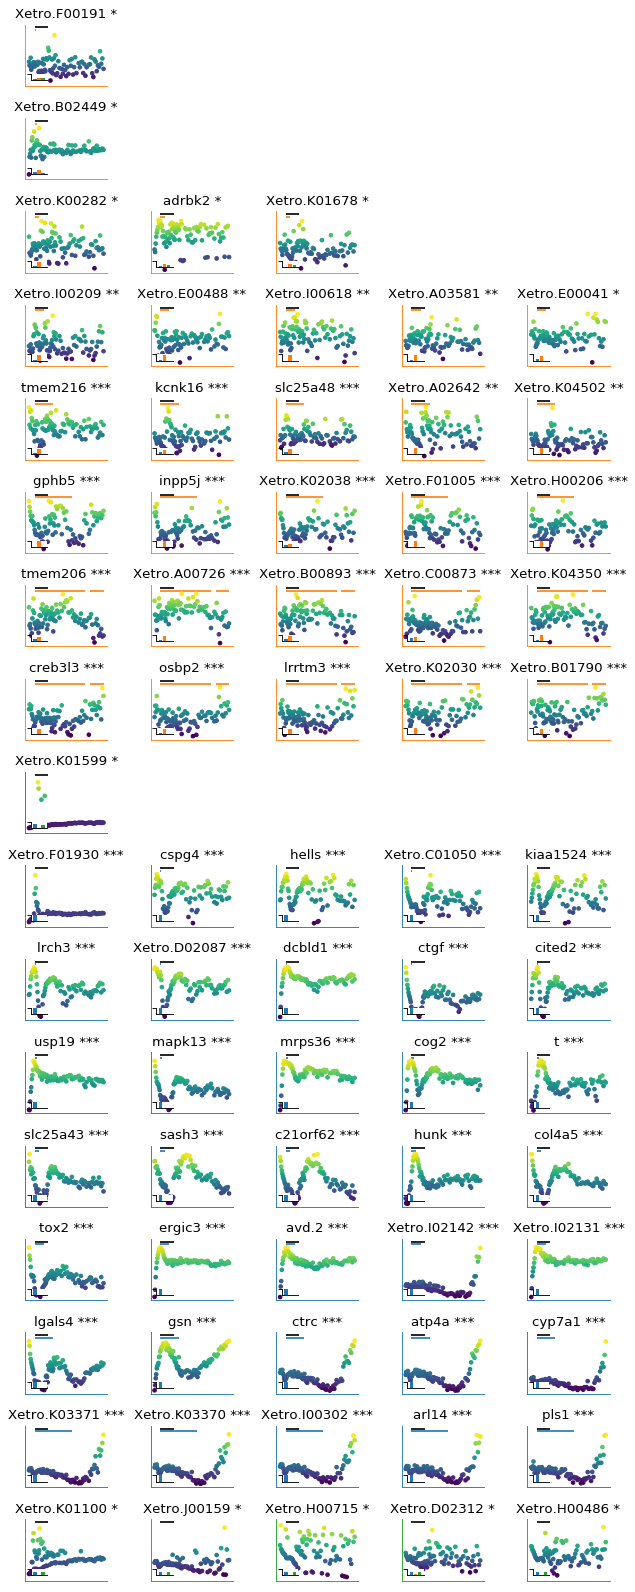

In [18]:
plt.figure(figsize=(8, 20), dpi=80)

N = 5
N_rows = top_per_ls.replace(np.nan, 0).groupby(['model', 'l']).size().shape[0]
for j, T in enumerate(top_per_ls.replace(np.nan, 0).groupby(['model', 'l'])):
    _, group = T
    for i, idx in enumerate(group.index):
        r = top_per_ls.loc[idx]
        ax = plt.subplot(N_rows, N, j * N + i + 1)

        plt.scatter(sample_info.hpf, res[r['g']], c=res[r['g']], s=10, rasterized=True);

        s = ' *'
        if r['qval'] < 0.01:
            s = ' **'

        if r['qval'] < 0.001:
            s = ' ***'

        name = r['g'].split('|')[-1].replace('unnamed', '')
        if name == '':
            name = r['g'].split('|')[0]
        plt.title(name + s)
        
        plt.xticks([])
        plt.yticks([])
        
        if 5 + r['l'] < 64:
            plt.hlines(ax.get_ylim()[1], 5, 5 + r['l'], color=model_colors[r['model']], zorder=0)
            
        else:
            if r['model'] != 'linear':
                y0 = ax.get_ylim()[1]
                plt.hlines(y0, 5, 50, color=model_colors[r['model']], zorder=0)
                plt.hlines(y0, 54, 66, color=model_colors[r['model']], zorder=0)

        plt.hlines(ax.get_ylim()[1], 5, 5 + 12)
        
        for spine in ax.spines.values():
            spine.set_edgecolor(model_colors[r['model']])
            
        # Make insert with model probabilities
        ins_ax = inset_axes(ax, width='20%', height='10%', loc=3)
        plt.bar((1, 2, 3), top_per_ls.loc[idx][['SE_prob', 'PER_prob', 'linear_prob']], color=['C0', 'C1', 'C2'])
        plt.ylim(0, 1);
        plt.xticks([], [])
        plt.xlim(-0.0, 4)
        plt.yticks([1], ['']);

plt.tight_layout()
plt.savefig('top_frog_gene_grid.pdf')

In [19]:
sample_info.hpf.max()

66.0

In [20]:
import SpatialDE.plot

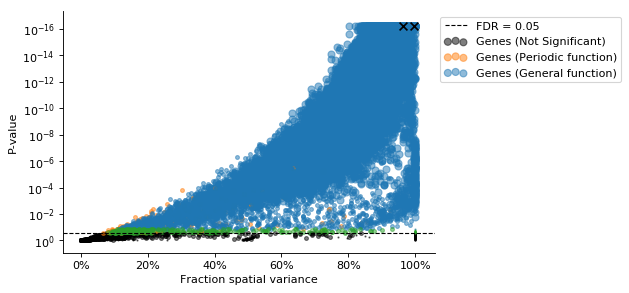

In [21]:
plt.figure(figsize=(6, 4), dpi=80)

SpatialDE.plot.FSV_sig(results, ms_results, covariate_names=['log_num_genes', 'log_ERCC'])

plt.savefig('frog_FSV_pval.pdf', dpi=200, bbox_inches='tight');

In [22]:
from sklearn.preprocessing import scale

In [23]:
top_genes = ms_results.sort_values('qval', ascending=True).head(400)

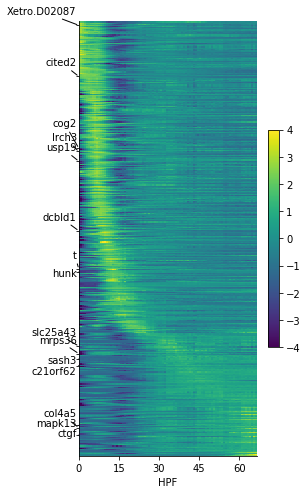

In [39]:
idx = np.argsort(np.argmax(dfm[top_genes['g']].as_matrix(), 0))[::-1]

figsize(4, 8)
plt.pcolormesh(scale(dfm[top_genes.iloc[idx]['g']].T, 1), vmax=4, vmin=-4, rasterized=True);
cbar = plt.colorbar(shrink=0.5);
cbar.solids.set_rasterized(True) 

x_locs = [0, 20, 40, 60, 80]
plt.xticks(x_locs, [int(i) for i in np.linspace(0, 66, 89)[x_locs]]);
plt.xlabel('HPF');

new_df = top_genes.iloc[idx][['g']].copy()
new_df['pos'] = np.arange(new_df.shape[0])
labels = new_df.merge(top_per_ls, on='g', how='inner')

plt.yticks(labels['pos'], [''] * len(labels['g']));

y_offsets = {
    'ctgf': -1,
    'mapk13': -1,
    'tctn2': -2,
    'cog2': 20,
    'c21orf62': -8,
    'sash3': -4,
    'bix1.1': -2,
    'hunk': -4
}
x_offsets = {
    'bix1.1': -15,
    'itpkc': -10,
    'Xetro.K04277': -8,
}
for i, r in labels.iterrows():
    xy = (0, r['pos'])
    name = r['g'].split('|')[-1].replace('unnamed', '')
    if name == '':
        name = r['g'].split('|')[0]

    xyt = (xy[0] + x_offsets.get(name, -1), xy[1] + y_offsets.get(name, 10))
    plt.annotate(name, xy, xyt, horizontalalignment='right', arrowprops={'arrowstyle': '-'})

plt.savefig('top_frog_heatmap.pdf', bbox_inches='tight');

In [32]:
labels

,g,pos,Unnamed: 0,BIC,FSV,LLR,M,l,max_delta,max_ll,...,n,s2_FSV,s2_logdelta,time,PER_prob,SE_prob,linear_prob,pval,qval,max_ll_null
0,Xetro.E00822|ctgf,19,3372,-23.627252,0.983837,74.732779,4,1.006862,0.015906,20.790899,...,89,0.000011,0.032199,0.000921,5.600438e-46,1.0,1.095927e-63,5.551115e-17,7.522790e-17,-53.941880
1,Xetro.H00629|col4a5,26,19124,-69.290135,0.964620,99.638856,4,4.055081,0.031095,43.622340,...,89,0.000047,0.031673,0.000740,2.384891e-69,1.0,2.550574e-85,5.551115e-17,7.522790e-17,-56.016515
2,Xetro.E01074|mapk13,28,11093,-103.002106,0.952082,89.897682,4,2.020620,0.046634,60.478326,...,89,0.000044,0.016940,0.000839,2.476663e-68,1.0,7.374174e-77,5.551115e-17,7.522790e-17,-29.419357
3,Xetro.B02133|c21orf62,83,17808,-61.291395,0.918729,85.281037,4,4.055081,0.074996,39.622970,...,89,0.000226,0.034303,0.000743,1.303092e-62,1.0,7.545379e-73,5.551115e-17,7.522790e-17,-45.658066
4,Xetro.H00653|sash3,89,19127,-127.293577,0.913968,82.085811,4,4.055081,0.079803,72.624061,...,89,0.000349,0.048180,0.000748,6.161304e-63,1.0,4.497990e-70,5.551115e-17,7.522790e-17,-9.461750
5,Xetro.E01048|mrps36,94,11082,-78.733779,0.961867,80.856685,4,2.020620,0.036734,48.344162,...,89,0.000020,0.011660,0.000905,2.179121e-63,1.0,5.255622e-69,5.551115e-17,7.522790e-17,-32.512522
6,Xetro.H00668|slc25a43,101,19130,-32.695855,0.844361,71.783097,4,4.055081,0.156273,25.325200,...,89,0.000563,0.030814,0.000830,2.196529e-49,1.0,3.998000e-61,5.551115e-17,7.522790e-17,-46.457896
7,Xetro.B02143|hunk,169,17809,23.178722,0.956060,94.791209,4,4.055081,0.038965,-2.612088,...,89,0.000081,0.036480,0.001035,1.259162e-72,1.0,4.142386e-81,5.551115e-17,7.522790e-17,-97.403297
8,Xetro.E00956|t,172,11051,171.157331,0.854551,70.928414,4,2.020620,0.157708,-76.601393,...,89,0.000220,0.013261,0.000754,3.333194e-52,1.0,2.209078e-60,5.551115e-17,7.522790e-17,-147.529806
9,Xetro.E00717|dcbld1,207,3344,46.570350,0.991433,75.759291,4,1.006862,0.008367,-14.307902,...,89,0.000002,0.020880,0.000916,1.067036e-61,1.0,1.406579e-64,5.551115e-17,7.522790e-17,-90.067194
